In [2]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io

In [28]:
def get_data(ntrain, ntest):
    # amount of subsampling
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = scipy.io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float32)
    y_data = data["u"][:, ::sub_y].astype(np.float32)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]

    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]

    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_data(1000, 1000)

print(x_train[0].shape, x_train[1].shape, y_train.shape)
print(x_test[0].shape, x_test[1].shape, y_test.shape)

(1000, 128) (128, 1) (1000, 128)
(1000, 128) (128, 1) (1000, 128)


Training example

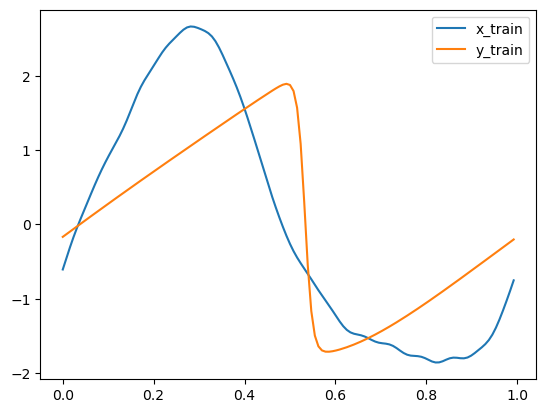

In [31]:
index_to_plot = 127

plt.figure()
plt.plot(x_train[1], x_train[0][index_to_plot, :].T, label="x_train")
plt.plot(x_train[1], y_train[index_to_plot, :].T, label="y_train")
plt.legend()
plt.show()

# Training

Check the PCA components

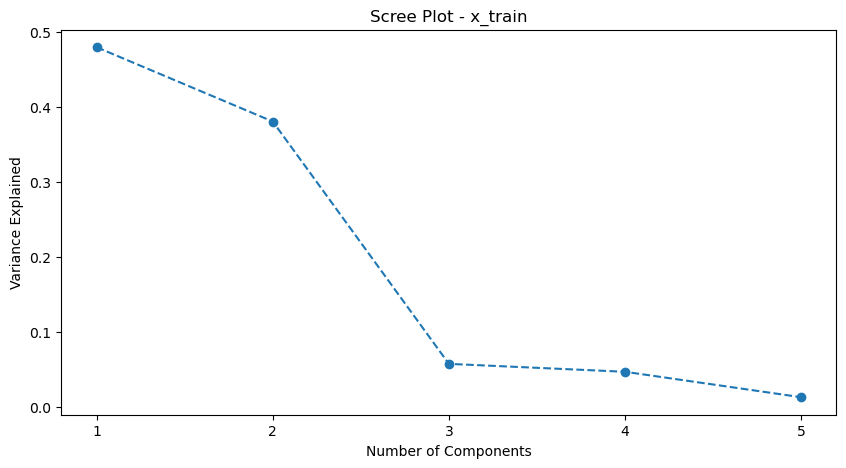

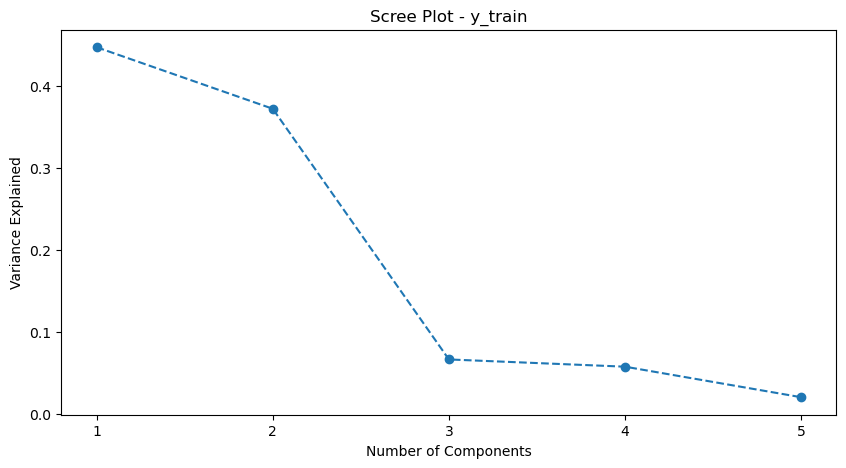

In [21]:
x_pca = PCA(n_components=5)
y_pca = PCA(n_components=5)
x_lowdim = x_pca.fit_transform(x_train[0])
y_lowdim = y_pca.fit_transform(y_train)

x_explained_variance = x_pca.explained_variance_ratio_
y_explained_variance = y_pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(x_explained_variance) + 1), x_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - x_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(x_explained_variance) + 1))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_explained_variance) + 1), y_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - y_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(y_explained_variance) + 1))
plt.show()

Train

In [48]:
low_dim_x = 3
low_dim_y = 5
GP_params = {'kernel': gpx.kernels.RBF(), 'mean_function': gpx.mean_functions.Zero()}

reg = first_model(low_dim_x=low_dim_x, low_dim_y=low_dim_y, low_dim_regressor='GP')
reg.fit(x_train[0], y_train, save=True)

print(reg.low_dim_regressor_list)

(1000, 3)
(1000, 5)
GP
(1000, 5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/tomcowperthwaite/opt/anaconda3/envs/

         Current function value: 87.274666
         Iterations: 30
         Function evaluations: 192
         Gradient evaluations: 178


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: 80.590775
         Iterations: 25
         Function evaluations: 89
         Gradient evaluations: 78


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: 378.379181
         Iterations: 15
         Function evaluations: 116
         Gradient evaluations: 104


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/gpjax/dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


         Current function value: 1005.101379
         Iterations: 17
         Function evaluations: 91
         Gradient evaluations: 79


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 335.195404
         Iterations: 17
         Function evaluations: 101
         Gradient evaluations: 90
(1000, 5)
[<models.GP_regressor object at 0x7fdb23cadf90>, <models.GP_regressor object at 0x7fdb23c8e050>, <models.GP_regressor object at 0x7fdb23c59e10>, <models.GP_regressor object at 0x7fdb23c59c90>, <models.GP_regressor object at 0x7fdb23c5aef0>]


See how well the low dim regressor is doing

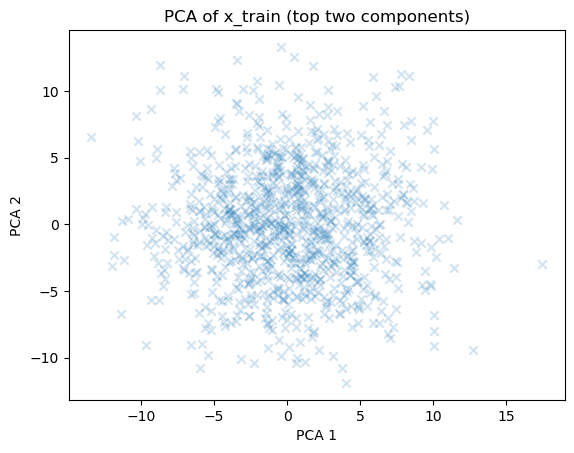

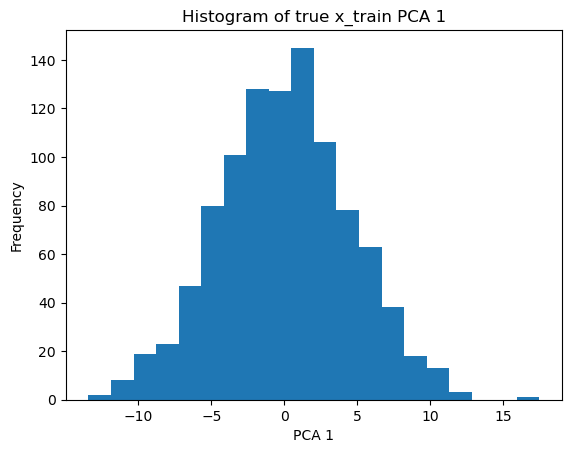

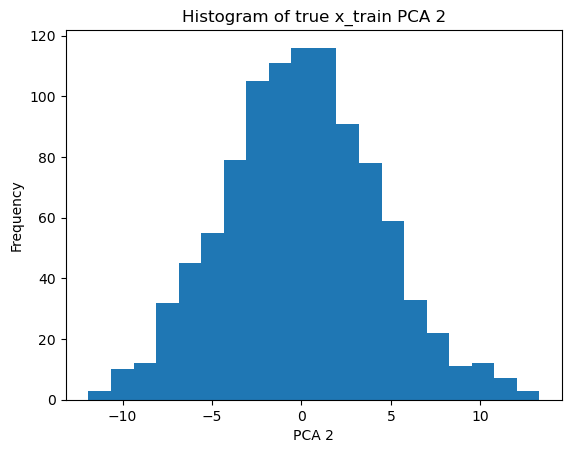

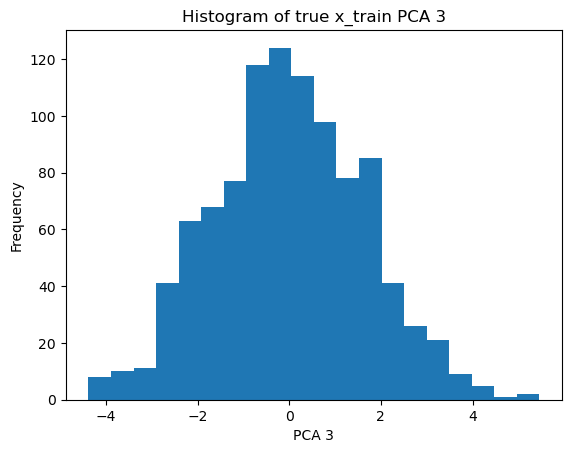

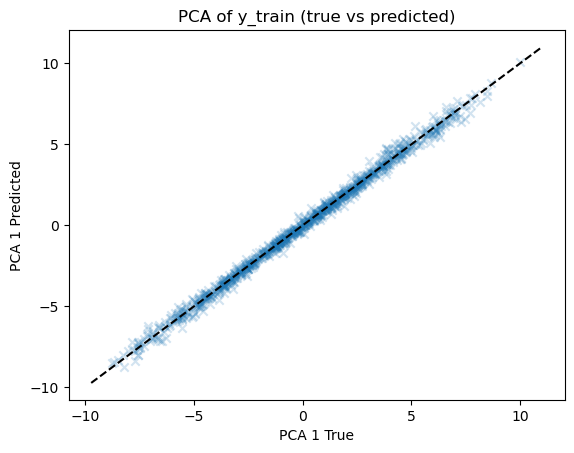

MSE: 0.06037451786837463
Correlation: 0.9976965570158655


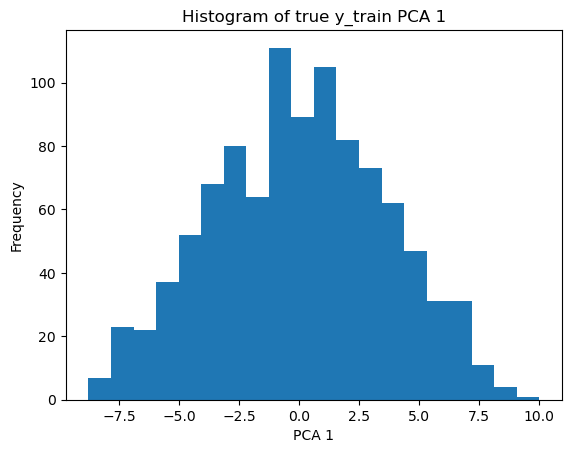

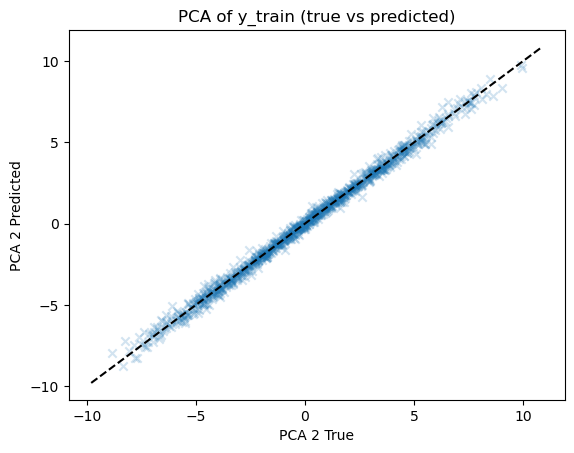

MSE: 0.06066769265749637
Correlation: 0.997510551234304


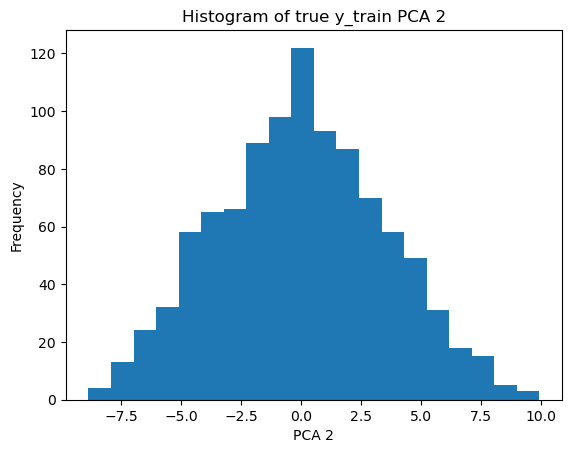

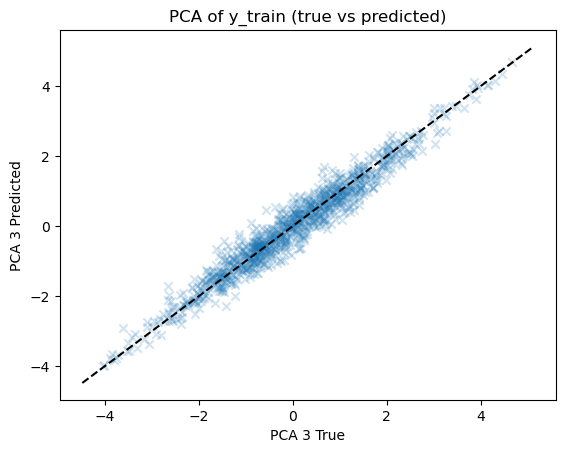

MSE: 0.10524750469481621
Correlation: 0.9735500441039768


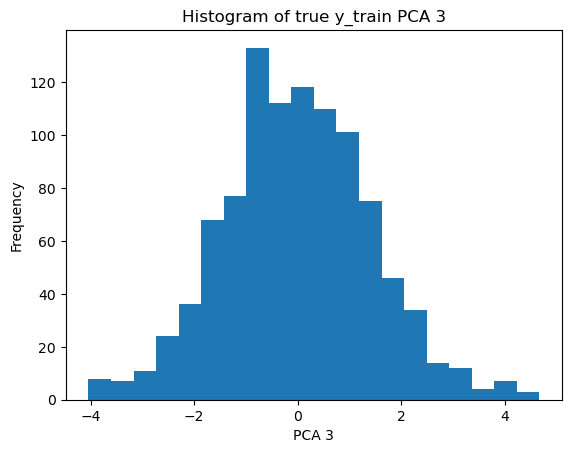

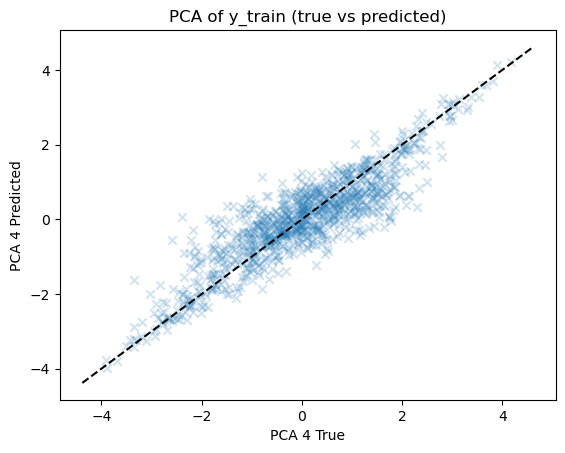

MSE: 0.39335541472727426
Correlation: 0.8867764684215689


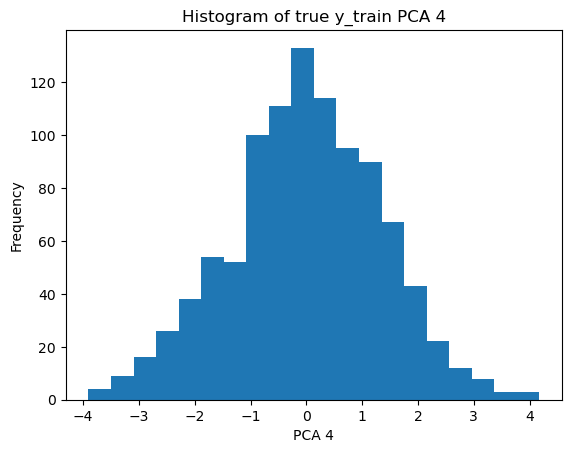

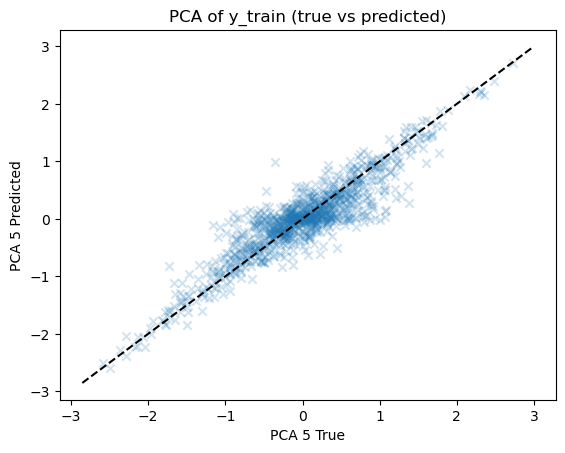

MSE: 0.09385150006882749
Correlation: 0.911987287568455


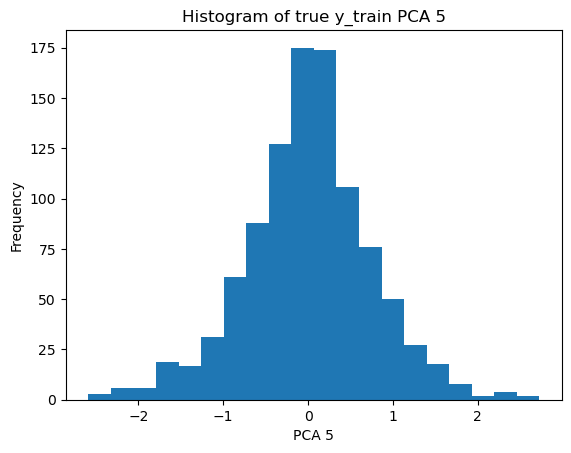

In [49]:
# assess how well the low-dimensional regression is doing

if low_dim_x > 1:
    plt.figure()
    plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of x_train (top two components)')
    plt.show()
if low_dim_x == 1:
    for i in range(low_dim_y):
        plt.figure()
        plt.scatter(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim[:, i], marker='x', alpha=0.2)
        plt.plot(reg.X_train_low_dim[:, 0], reg.low_dim_regressor_list[i].predict(reg.X_train_low_dim), color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        plt.xlabel('x_train PCA 1')
        plt.ylabel(f'y_train PCA {i+1}')
        plt.show()

for i in range(low_dim_x):
    plt.figure()
    plt.hist(reg.X_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true x_train PCA {i+1}')
    plt.show()


for i in range(low_dim_y):
    plt.figure()
    ax = plt.gca()
    plt.scatter(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i], marker='x', alpha=0.2)
    plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    plt.xlabel(f'PCA {i+1} True')
    plt.ylabel(f'PCA {i+1} Predicted')
    plt.title('PCA of y_train (true vs predicted)')
    plt.show()

    mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'MSE: {mse}')
    r = np.corrcoef(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'Correlation: {r[0, 1]}')

    plt.figure()
    plt.hist(reg.Y_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true y_train PCA {i+1}')
    plt.show()

# Testing

In [50]:
y_test_pred = reg.predict(x_test[0])
rmse, r2 = reg.test(x_test[0], y_test)
L2_relative_error = np.sqrt(np.sum((y_test - y_test_pred) ** 2, axis = 1))/np.sqrt(np.sum(y_test ** 2, axis = 1))

print(f' average L2 error: {L2_relative_error.mean()}')

 average L2 error: 0.27981446710787866


Plot the distributions of errors (not sure if RMSE and R2 are the best here)

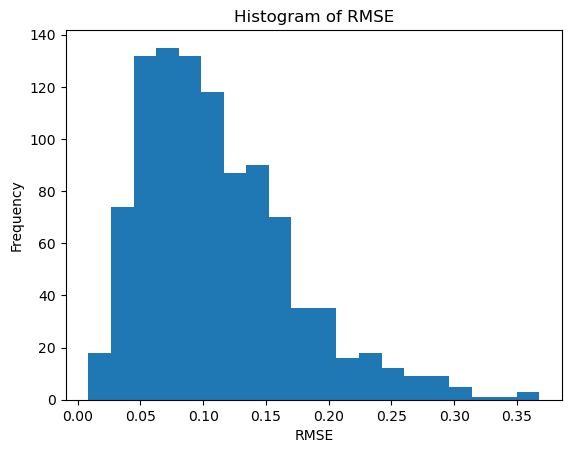

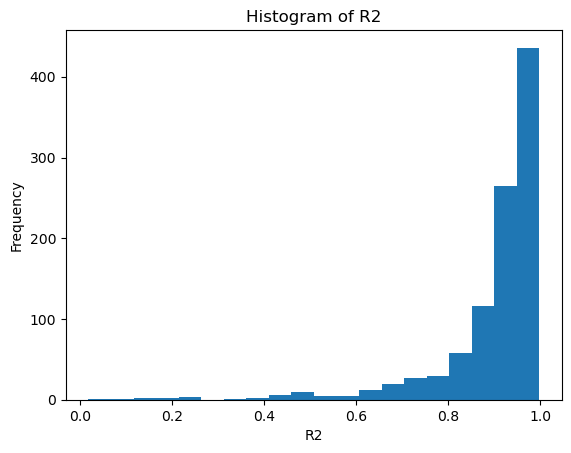

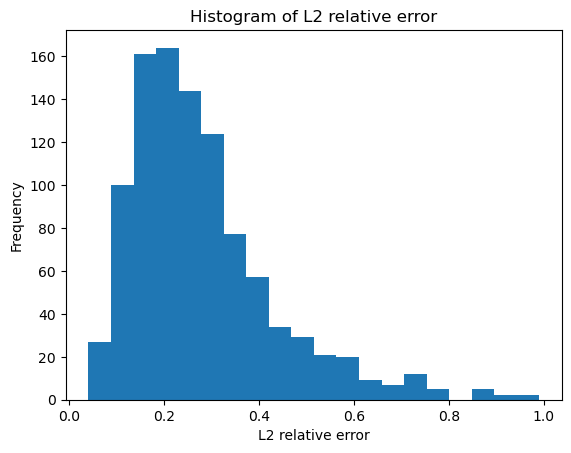

In [51]:
plt.figure()
plt.hist(rmse, bins=20)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE')
plt.show()

plt.figure()
plt.hist(r2, bins=20)
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.title('Histogram of R2')
plt.show()

plt.figure()
plt.hist(L2_relative_error, bins=20)
plt.xlabel('L2 relative error')
plt.ylabel('Frequency')
plt.title('Histogram of L2 relative error')
plt.show()

plot an example test

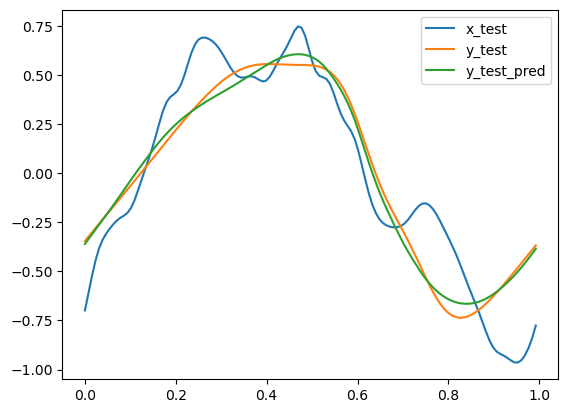

In [53]:
index_to_plot = 127

plt.figure()
plt.plot(x_test[1], x_test[0][index_to_plot, :].T, label="x_test")
plt.plot(x_test[1], y_test[index_to_plot, :].T, label="y_test")
plt.plot(x_test[1], y_test_pred[index_to_plot, :].T, label="y_test_pred")
plt.legend()
plt.show()
